In [1]:
'''
We use investing.com as the source. 
'''

# Import packages
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_datareader as pdr
import investpy

# Statistical libraries
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Libraries for machine learning
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score



# Set the date bounds
start = '01/01/2019'                                   #dt.datetime(2019,1,1)
end = dt.datetime.now().strftime('%d/%m/%Y')


In [2]:
# Stocks and assets
# CKH = investpy.get_stock_historical_data(stock = '0001', country = 'hong kong', from_date = start, to_date = end)
# TCEHY = investpy.get_stock_historical_data(stock = '0700', country = 'hong kong', from_date = start, to_date = end)
# BTCUSD = investpy.get_stock_historical_data(stock = '0388', country = 'hong kong', from_date = start, to_date = end)
# BTCUSD = investpy.get_currency_cross_historical_data(currency_cross = 'USD/JPY', from_date = start, to_date = end)
# GBPJPY = investpy.get_currency_cross_historical_data(currency_cross = 'GBP/JPY', from_date = start, to_date = end)
# AAPL = investpy.get_stock_historical_data(stock = 'AAPL', country = 'United States', from_date = start, to_date = end)
BTCUSD = investpy.get_crypto_historical_data(crypto='bitcoin', from_date = start, to_date = end)



In [3]:
# Define the SMA parameters
SMA1 = 15
SMA2 = 20

# Calculate the SMA values
BTCUSD['SMA_' + str(SMA1)] = BTCUSD['Close'].rolling(SMA1).mean()
BTCUSD['SMA_' + str(SMA2)] = BTCUSD['Close'].rolling(SMA2).mean()

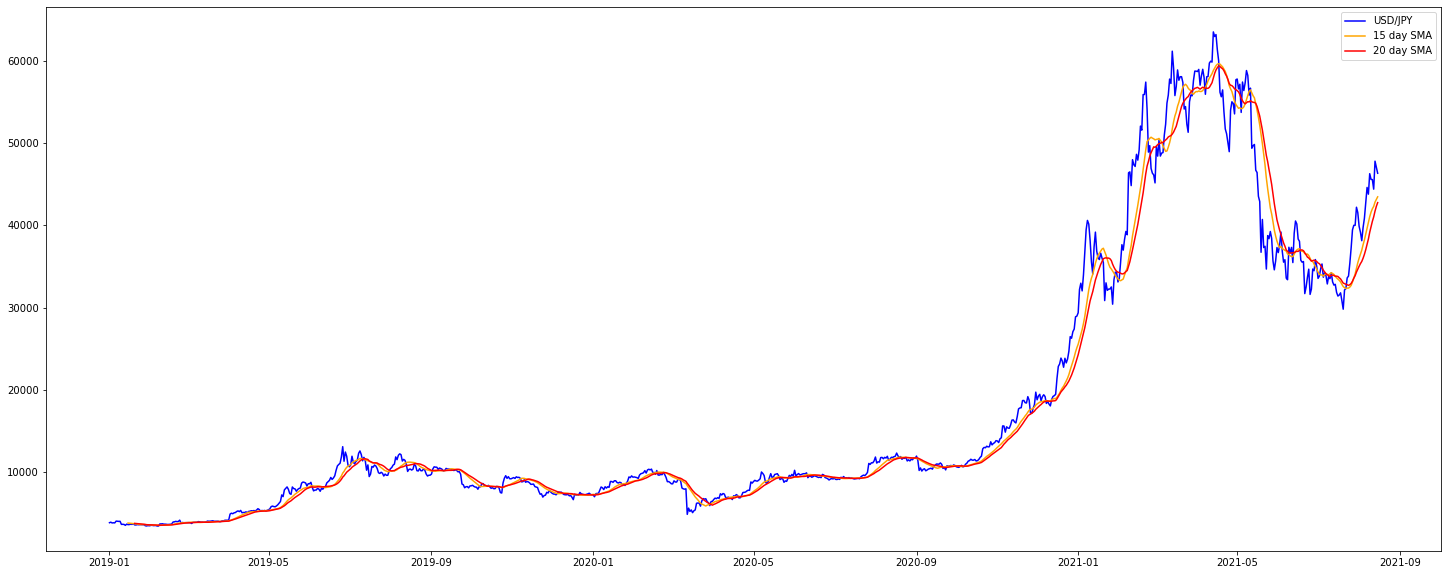

In [4]:
# Plot close, SMA1 and SMA2
plt.figure(figsize=(25,10))
plt.plot(BTCUSD['Close'], label = 'USD/JPY', color = 'blue')
plt.plot(BTCUSD['SMA_' + str(SMA1)], label = str(SMA1) + ' day SMA', color = 'orange')
plt.plot(BTCUSD['SMA_' + str(SMA2)], label = str(SMA2) + ' day SMA', color = 'red')
plt.legend(loc='upper right')
plt.show()

In [5]:
#Now creating NextDayOpen column for prediction
ln=len(BTCUSD)
lnop=len(BTCUSD['Open'])
BTCUSD['NextDayOpen'] = np.nan


for i in range(0,ln-1):
    BTCUSD['NextDayOpen'][i] = BTCUSD['Open'][i+1]


<ipython-input-5-26b52704bb54>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTCUSD['NextDayOpen'][i] = BTCUSD['Open'][i+1]


In [6]:
# Insert a column of one in the main dataframe
BTCUSD['One'] = 1

# Delete the last row
data = BTCUSD.dropna()

# shuffle the data
data = shuffle(data, random_state = 0)

# Divide data into train and test
X_train, X_test, y_train, y_test = train_test_split(data[['One','Open','Close','SMA_' + str(SMA1), 'SMA_' + str(SMA2)]], data['NextDayOpen'], test_size = 0.2, random_state = 0)

# Linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)


In [7]:
# Show the coefficient of the linear regression
# print('Coefficient: ', reg.coef_)

# Mean squared error
# not include open: 0.0013645649492197841
# include open: 0.0014518005592936802
# No close: 0.31230684915353324
print("mean squared error:  ", mean_squared_error(y_test, y_pred))

mean squared error:   379.96834388269605


In [8]:
# Variance score 
# not include open: 0.9997254211563988
# Include open: 0.9997078675376073
# no close: 0.9371573676003272
print("Variance score: ",   r2_score(y_test, y_pred))

Variance score:  0.9999985413634044


In [22]:
reg.predict(BTCUSD[['One','Open','Close','SMA_' + str(SMA1), 'SMA_' + str(SMA2)]][-1:])[0]

46340.87987799154

In [19]:
dfra = pd.DataFrame(y_test.copy())
dfra['pred'] = y_pred

In [27]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}') 
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}') 
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    
def Augmented_Dickey_Fuller_Test_func(series , column_name): 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value','No Lags Used','Number of Observations Used']) 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>") 
        print("Reject the null hypothesis") 
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis") 
        print("Data is non-stationary")


In [30]:
Augmented_Dickey_Fuller_Test_func(BTCUSD['Close'].diff().dropna(), 'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                -7.111448e+00
p-value                        3.929427e-10
No Lags Used                   2.200000e+01
Number of Observations Used    9.340000e+02
Critical Value (1%)           -3.437371e+00
Critical Value (5%)           -2.864639e+00
Critical Value (10%)          -2.568420e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


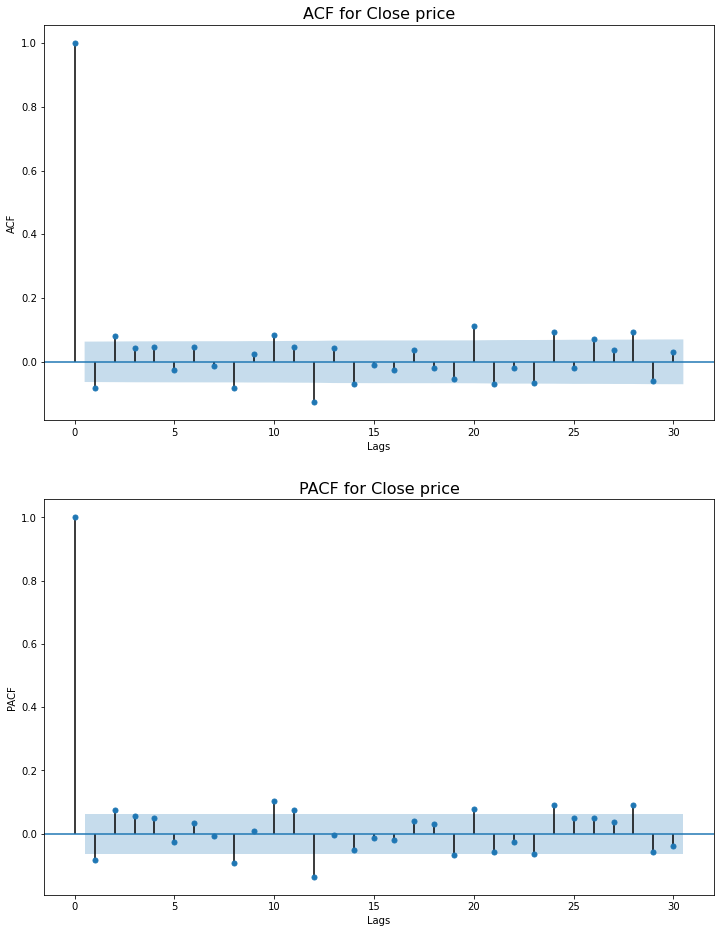

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,16))
_ = plot_acf(BTCUSD['Close'].diff().dropna(), ax = ax1)
_ = ax1.set_title('ACF for Close price', fontsize=16)
_ = ax1.set_xlabel('Lags')
_ = ax1.set_ylabel('ACF')

_ = plot_pacf(BTCUSD['Close'].diff().dropna(), ax=ax2)
_ = ax2.set_title('PACF for Close price', fontsize=16)
_ = ax2.set_xlabel('Lags')
_ = ax2.set_ylabel('PACF')

plt.show()